In [3]:
from mnist import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import argparse
import os
import sys
from torchvision import datasets, transforms

import wandb
from tqdm import tqdm
    
argparser = argparse.ArgumentParser()
##argparser.add_argument('-d','--input_size', type=int, default=28*28, help='model name')
argparser.add_argument('-n','--hidden_size', type=int, default=8192, help='hidden size')


argparser.add_argument('-r','--range', type=float, default=10.0, help='set the range of the input data')
argparser.add_argument('-N','--num-samples', type=int, default=32, help='set the number of the input data centers')
argparser.add_argument('-a','--alpha', type=float, default=90, help='detenrmine the angle between close input data points')
argparser.add_argument('-s','--sigma', type=float, default=0.05, help='noise level')

argparser.add_argument('-S','--seed', type=int, default=0, help='set the random seed')
argparser.add_argument('-D','--device', type=int, default=0, help='set the device')

argparser.add_argument('-x','--dist', type=int, default=1.0, help='set the distance between the two neighbouring input data points')

argparser.add_argument('--lr', type=float, default=0.1, help='learning rate')
argparser.add_argument('--wd', type=float, default=0.1, help='weight decay')
argparser.add_argument('-b','--batch-size', type=int, default=(64*3), help='batch size')
argparser.add_argument('-E','--epochs', type=int, default=1000, help='epochs')

argparser.add_argument('--misc', action='store_true', default=False, help='miscellaneous')

argparser.add_argument('-o','--obtuse', action='store_true', default=False, help='obtuse angle in the triangle')


argparser.add_argument('--cosine', action='store_true', default=False, help='use cosine learning rate')

argparser.add_argument('-e','--predict-e', action='store_true', default=False, help='predict epsilon')


argparser.add_argument('--test-samples', type=int, default=1000, help='set the number of the test samples')
argparser.add_argument('--noise-taken-per-sample', type=int, default=64, help='set the number of the noise samples taken per test sample')
argparser.add_argument('--pca-dims', type=int, default=-1, help='number of PCA dims to reduce to')

argparser.add_argument('--cheat-init', action='store_true', default=False, help='initializae the network with direction of the data')

_StoreTrueAction(option_strings=['--cheat-init'], dest='cheat_init', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='initializae the network with direction of the data', metavar=None)

In [5]:
txt = "-E 200000 -s 0.05 --wd 1E-8 -n 1024 --noise-taken-per-sample 4096 -b 4096 --lr 1E-5 --pca-dims -1 -D 7 --misc"
args = argparser.parse_args(txt.split())

In [6]:
torch.manual_seed(args.seed)

#set the device
device = torch.device("cuda:"+str(args.device) if torch.cuda.is_available() else "cpu")

#set the input data

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

success = False
for i in tqdm(range(10000), desc='Looking at triangles...'):
    try:
        X , idx1, idx2  = create_mnist_datapoints(ds, classes = [0], mindeg=95, maxdeg=180)
        Xsharp , _, _  = create_mnist_datapoints(ds, classes = [0], mindeg=0, maxdeg=85, idx1_fixed=idx1, idx2_fixed=idx2)
        success = True
    except ValueError:
        success = False
    if success:
        break

X, pca_V = getPCA(X, args.pca_dims)
X = X.to(device)

X = X - X.mean(dim=0)

v0 = X[1] - X[0]
v1 = X[2] - X[0]

deg = torch.arccos(torch.sum(v0*v1)/torch.sqrt(torch.sum(v0*v0)*torch.sum(v1*v1)))*180/np.pi
print("degree1: ", deg)


##run(args, X, deg, v0, v1, device)
    
    
input_size = X.shape[1]

model = TwoLayer(input_size, args.hidden_size).to(device)


if args.cheat_init:
    p = model.fc1.weight

    a = torch.randn(p.shape[0])
    b = torch.randn(p.shape[0])

    ## move p.data to the projection on the plane spanned by v0 and v1
    u0 = v0 / torch.norm(v0)
    u1 = v1 - torch.sum(v1*u0)*u0
    u1 = u1 / torch.norm(u1)
    u0 = u0.view(-1,1)
    u1 = u1.view(-1,1)
    p.data = torch.sum(p.data @ u0, dim=1, keepdims = True) @ u0.t() + torch.sum(p.data @ u1, dim=1, keepdims = True) @ u1.t()


model2 = None
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(f"number of trainable parameters: {num_params}\n")

Looking at triangles...:   0%|                                                                                                    | 8/10000 [00:31<10:55:41,  3.94s/it]


degree1:  tensor(96.1098, device='cuda:7')
TwoLayer(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=784, bias=True)
  (unreg_linear): Linear(in_features=784, out_features=784, bias=False)
)
number of trainable parameters: 2222096



In [ ]:
# add weight decay to non-bias weights
paramlist = add_weight_decay(model, weight_decay=args.wd, skip_list = ("unreg_linear.weight",)) #1e-5
optimizer = torch.optim.Adam(paramlist, lr=args.lr)
##optimizer = torch.optim.SGD(paramlist, lr=args.lr)


if args.cosine:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=0.0)

#set the loss function
loss_func = nn.MSELoss()

#set the wandb
if not args.misc:
    wandb.init(project="phased_denoiser", entity='dl-projects' ,  config=args)
    ##wandb.watch(model, log="all")


##create a data loader from the data points:

#set the training loop



repeats = (3+args.batch_size-1)//3

bar = tqdm( range(args.epochs), total = args.epochs, desc="training")


reset_samples = args.noise_taken_per_sample // repeats


model.train()

init_state = torch.random.get_rng_state()

noise_state = init_state

decreased = False

for epoch in bar:

    if args.noise_taken_per_sample > 0 and epoch % reset_samples == 0:
        noise_state = init_state

    optimizer.zero_grad()

    total_loss = 0

    x = X.repeat(repeats, 1)


    tmp_state = torch.random.get_rng_state()
    torch.random.set_rng_state(noise_state)

    noise = torch.randn_like(x)
    noise_state = torch.random.get_rng_state()
    torch.random.set_rng_state(tmp_state)


    y = x + args.sigma* noise

    y = y[torch.randperm(y.shape[0])[:args.batch_size]]

    y = x + args.sigma* noise


    if args.predict_e:
        eat = model(y)
        loss = loss_func(eat, noise )
    else:
        xat = model(y)
        loss = loss_func(xat, x)


    loss.backward()

    optimizer.step()

    if args.cosine:
        scheduler.step()


    total_loss = loss.item()


    L2 = model.fc1.weight.norm().item() + model.fc2.weight.norm().item() 

    if not decreased:
        if deg > 90 and L2 <= 8.1:
            paramlist = add_weight_decay(model, weight_decay=args.wd/100, skip_list = ("unreg_linear.weight",)) #1e-5
            optimizer = torch.optim.Adam(paramlist, lr=args.lr)
            decreased = True
        elif deg <= 90 and L2 <= 12.1:
            paramlist = add_weight_decay(model, weight_decay=args.wd/100, skip_list = ("unreg_linear.weight",)) #1e-5
            optimizer = torch.optim.Adam(paramlist, lr=args.lr)
            decreased = True

    if wandb.run is not None:
        wandb.log({"epoch": epoch, "loss": total_loss, 'learning rate': optimizer.param_groups[0]['lr'], 'L2': L2})

    bar.set_postfix(loss=total_loss, L2=L2)

##display(model, model2, device, args, deg, v0, v1, X, noise_state= init_state, grid_points = 250)

training:  18%|███████████████▉                                                                         | 35838/200000 [02:47<12:48, 213.59it/s, L2=22.9, loss=1.11e-8]

In [8]:
print("Done")

Done


In [16]:
def plot_theory2(X, ax, args, grid_points, grid_range, device, levels, deg):


    x_1 = X[0]
    x_2 = X[1] 
    x_3 = X[2]

    if deg > 90:

        x_2 = x_2 - x_1
        x_3 = x_3 - x_1
        x_1 = x_1 - x_1

        center = (x_1 + x_2 + x_3)/3 

        ##sigma = args.sigma * math.sqrt(x_1.shape[0])
        sigma = args.sigma * math.sqrt(2*math.log(args.noise_taken_per_sample))

        u_2 = x_2/torch.norm(x_2)
        u_3 = x_3/torch.norm(x_3)

        slope = (torch.norm(x_2))/(torch.norm(x_2)-2*sigma)
        g_2 = lambda t: torch.where(t < sigma, torch.zeros_like(t), torch.where(t > torch.norm(x_2)-sigma, torch.norm(x_2), (t-sigma)*slope))

        slope = (torch.norm(x_3))/(torch.norm(x_3)-2*sigma)
        g_3 = lambda t: torch.where(t < sigma, torch.zeros_like(t), torch.where(t > torch.norm(x_3)-sigma, torch.norm(x_3), (t-sigma)*slope))


        f = lambda y: u_2*g_2(torch.sum(u_2*y)) + u_3*g_3(torch.sum(u_3*y))

    elif deg <= 90:
        x_0 = (x_1 + x_2 + x_3)/3 

        u_1 = x_1/torch.norm(x_1 - x_0)
        u_2 = x_2/torch.norm(x_2 - x_0)
        u_3 = x_3/torch.norm(x_3 - x_0)

        rho = args.sigma * math.sqrt(2*math.log(args.noise_taken_per_sample))

        # \bv f^*(\vy) = \vu_1 \phi_1(\vu_1^\T(\vy-\vx_0)) + \vu_2 \phi_2(\vu_2^\T(\vy-\vx_0)) + \vu_3 \phi_3(\vu_3^\T(\vy-\vx_0)) - \vx_0
        # where $\vx_0 \in \R^d$ is the orthocenter of the triangle, 
        # and for $i=1,2,3$ we have $\phi_i(\vy) = s_i([t-a_i]_+-[t-b_i]_+)$ with $\vu_i = \frac{\vx_i-\vx_0}{\|\vx_i-\vx_0\|}$,
        #  for either $\vx_j$ with $j\neq i$, , and 

        # $a_i = \vu_i^\T(\vx_j-\vx_0) + \rho$

        a_1 = torch.sum(u_1*(x_2-x_0)) + rho
        a_2 = torch.sum(u_2*(x_3-x_0)) + rho
        a_3 = torch.sum(u_3*(x_1-x_0)) + rho
        # $b_i = \|\vx_i-\vx_0\|-\rho$
        b_1 = torch.norm(x_1-x_0) - rho
        b_2 = torch.norm(x_2-x_0) - rho
        b_3 = torch.norm(x_3-x_0) - rho

        # $s_i = \|\vx_i-\vx_0\|/(b_i-a_i)$.
        slope1 = torch.norm(x_1-x_0)/(b_1-a_1)
        slope2 = torch.norm(x_2-x_0)/(b_2-a_2)
        slope3 = torch.norm(x_3-x_0)/(b_3-a_3)
        ##breakpoint()

        phi_1 = lambda t: torch.where(t < a_1, torch.zeros_like(t), torch.where(t > b_1, torch.norm(x_1-x_0), (t-a_1)*slope1))
        phi_2 = lambda t: torch.where(t < a_2, torch.zeros_like(t), torch.where(t > b_2, torch.norm(x_2-x_0), (t-a_2)*slope2))
        phi_3 = lambda t: torch.where(t < a_3, torch.zeros_like(t), torch.where(t > b_3, torch.norm(x_3-x_0), (t-a_3)*slope3))

        f = lambda y: u_1*phi_1(torch.sum(u_1*(y-x_0))) + u_2*phi_2(torch.sum(u_2*(y-x_0))) + u_3*phi_3(torch.sum(u_3*(y-x_0))) + x_0
        center = 0

    v0 = x_2 - x_1
    v1 = x_3 - x_1
    u0 = v0 / v0.norm()
    u1 = v1 - torch.dot(u0, v1)*u0
    ##u1 = v1
    u1 = u1 / u1.norm()


    gridvals = torch.linspace(-grid_range, grid_range, grid_points, device=device)

    X0 = torch.zeros((grid_points, grid_points))
    X1 = torch.zeros((grid_points, grid_points))
    X_orth = torch.zeros(grid_points, grid_points)



    Y = torch.zeros((2, grid_points, grid_points))

    for i, a1 in tqdm(enumerate(gridvals), total = grid_points):
        for j, a2 in enumerate(gridvals):
            y = a1*v0 + a2*v1 
            
            xhat = f(y.view(1, -1) + center ) - center
            
            x0, x1 ,x_orth = project(xhat , u0, u1)
            
            X0[i,j]=x0.item()
            X1[i,j]=x1.item()
            X_orth[i,j]=x_orth.item()
            Y[0,i,j], Y[1,i,j], _ = project(y , u0, u1)

    X0 = X0.cpu().numpy()
    X1 = X1.cpu().numpy()
    X_orth = X_orth.cpu().numpy()

    ax[0].set_title("Theory- Direction 0")
    ax[0].contourf(Y[0], Y[1],X0, levels = levels)

    ax[1].set_title("Direction 1")
    ax[1].contourf(Y[0], Y[1],X1, levels = levels)
    
    ##ax[2].set_title("Orthogonal Direction")
    ##ax[2].contourf(Y[0], Y[1],X_orth, levels = levels)


def display2(model, model2, device, args, deg, v0, v1, X, noise_state,  grid_range =3 , grid_points = 100):

    gridvals = torch.linspace(-grid_range, grid_range, grid_points, device=device)

    u0 = v0 / v0.norm()
    u1 = v1 - torch.dot(u0, v1)*u0
    ##u1 = v1
    u1 = u1 / u1.norm()

    X0 = torch.zeros(grid_points, grid_points)
    X1 = torch.zeros(grid_points, grid_points)
    X_orth = torch.zeros(grid_points, grid_points)

    Y = torch.zeros((2, grid_points, grid_points))

    for i, a1 in tqdm(enumerate(gridvals), total = grid_points):
        for j, a2 in enumerate(gridvals):
            y = a1*v0 + a2*v1
            
            xhat = model(y)
            
            x0, x1 ,x_orth = project(xhat, u0, u1)
            
            X0[i,j]=x0.item()
            X1[i,j]=x1.item()
            X_orth[i,j]=x_orth.item()
            Y[0,i,j], Y[1,i,j], _ = project(y, u0, u1)

    v0_norm = v0.norm().cpu().item()
    v1_norm = v1.norm().cpu().item()
    ##Y = np.asarray(np.meshgrid(gridvals.cpu().numpy()*v0_norm , gridvals.cpu().numpy()*v1_norm))

    ##Y = -Y

    X0 = X0.cpu().numpy()
    X1 = X1.cpu().numpy()
    X_orth = X_orth.cpu().numpy()


    maxval = np.max(X0)
    maxval = np.maximum(np.max(X1), maxval)

    minval = np.min(X0)
    minval = np.minimum(np.min(X1), minval)



    levels = np.linspace(-3, 3, 31)

    fig, ax_all = plt.subplots(2,2,  figsize=(16,8),sharex='col', sharey='row', layout='constrained')

    ax = ax_all[:,0]
    axb = ax_all[:,1]


    ax[0].set_title("Results- Direction 0")
    CS = ax[0].contourf(Y[0], Y[1],X0, levels = levels )
    plot_points(X, u0, u1, v0, v1, ax[0], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)



    # Add the contour line levels to the colorbar

    # plt.figure()

    ax[1].set_title("Direction 1")
    ax[1].contourf(Y[0], Y[1],X1, levels = levels)
    plot_points(X, u0, u1, v0, v1, ax[1], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)

    # plt.figure()

    ##ax[2].set_title("Orthogonal Direction")
    ##ax[2].contourf(Y[0], Y[1],X_orth, levels = levels)
    ##plot_points(X, u0, u1, v0, v1, ax[2], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)


    plot_theory2(X, axb, args, grid_points, grid_range, device, levels, deg)

    plot_points(X, u0, u1, v0, v1, axb[0], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)
    plot_points(X, u0, u1, v0, v1, axb[1], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)
    ##plot_points(X, u0, u1, v0, v1, axb[2], sigma = args.sigma, noise_state = noise_state, N=args.noise_taken_per_sample)

    # plt.figure()

    plt.colorbar(CS, ax=axb)

    wd_log = np.log10(args.wd) if args.wd > 0 else -6
    wd_log = -np.round(wd_log)
    plt.savefig(f"figures/contour_deg_{int(np.round(deg.cpu()))}_D{args.pca_dims}_E{args.epochs}_wd{wd_log}.pdf")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.51it/s]


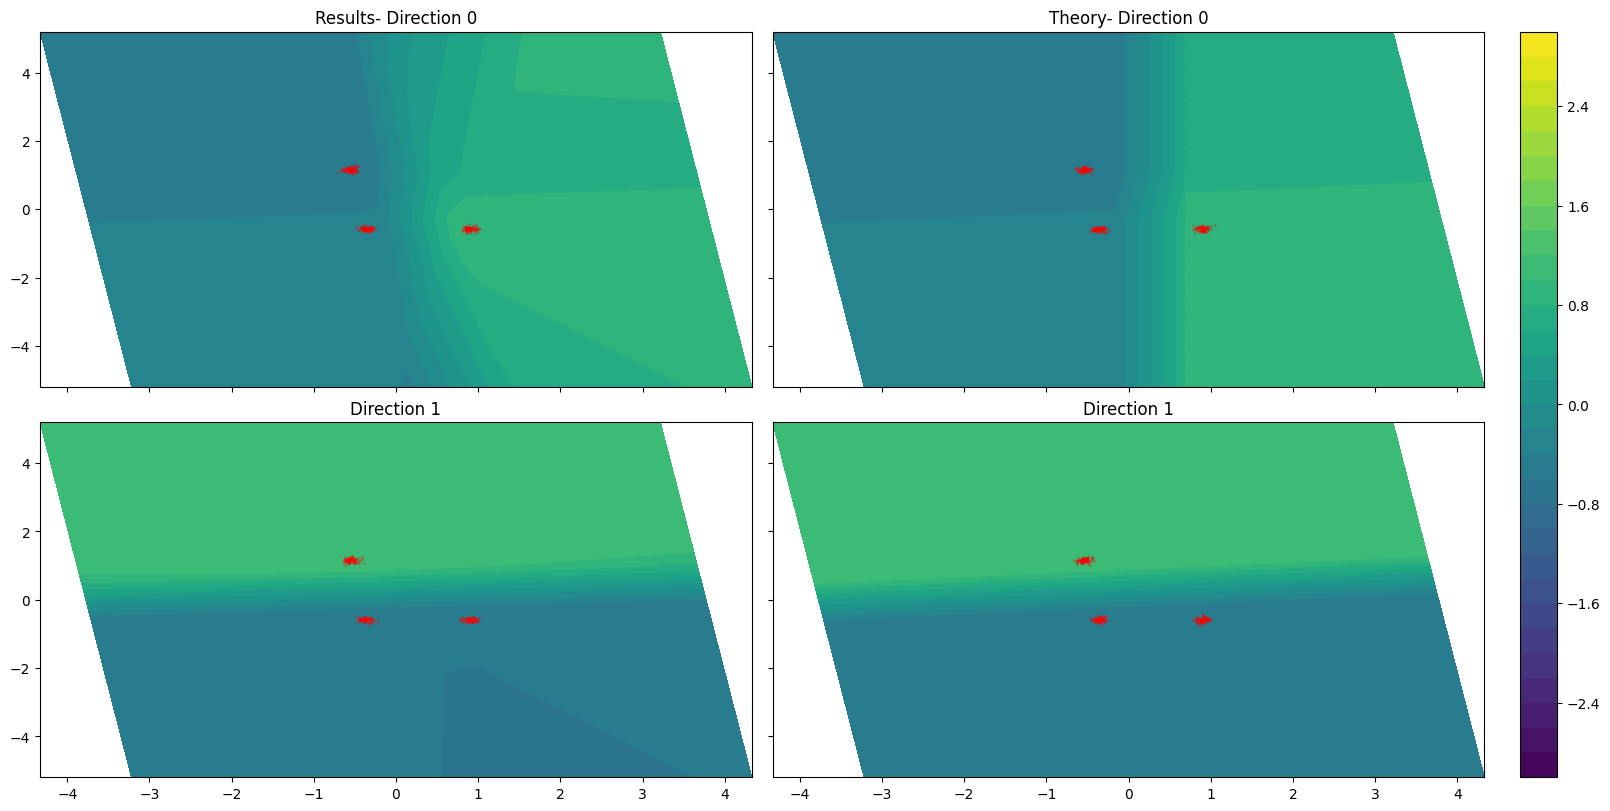

In [18]:
display2(model, model2, device, args, deg, v0, v1, X, noise_state= init_state, grid_points = 250)